In [2]:
# webstie https://nucleisegmentationbenchmark.weebly.com
# paper   https://drive.google.com/file/d/0ByERBiBsEbuTOEJISEpwSkR0SlE/view
import os
import re
import PIL
import time
import random
import shutil
import itertools
import collections
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from xml.dom import minidom
from PIL import Image


In [4]:
TRAIN_PATH = '../orig_data/Tissue images_png/'
XML_PATH   = '../orig_data/Annotations/'
OUT_PATH  = '../orig_data/external_TCGA_train/'  # manual create

train_ids = next(os.walk(TRAIN_PATH))[2]
xml_ids = next(os.walk(XML_PATH))[2]
print('train_ids = ' + str(len(train_ids)) + '\nxml_ids = ' + str(len(xml_ids)))
IMG_HEIGHT = 1000
IMG_WIDTH = 1000
IMG_CHANNELS = 1

if not os.path.isdir(OUT_PATH):
    os.mkdir(OUT_PATH) 


train_ids = 30
xml_ids = 30


In [5]:
def fill_circle(mask_img,vertex_list):
    # max x value for each y
    max_right = {}     
    for i in range(len(vertex_list)):
        current_y = vertex_list[i][0]
        current_x = vertex_list[i][1]
        if current_y not in max_right:
            max_right[current_y] = current_x 
        else:
            max_right[current_y] = max(max_right[current_y],current_x)
    
    for i in range(len(vertex_list)):
        current_y = vertex_list[i][0]
        current_x = vertex_list[i][1]
        mask_img[current_y,current_x:max_right[current_y]] = 255
    
    return mask_img

In [6]:
def check_valid_xy(y, x):
    if x >= IMG_WIDTH: x = IMG_WIDTH-1
    if y >= IMG_HEIGHT: y = IMG_HEIGHT-1                
    if x <= 0: x = 0
    if y <= 0: y = 0
    return y,x

In [7]:
def generate_miss_node(y, x, py, px):
    dist_x = int(x) - px
    dist_y = int(y) - py
    miss_node = []
    if max(abs(dist_y),abs(dist_x)) >= 2 and py != IMG_HEIGHT and px != IMG_WIDTH:
        a = int(x); b = px
        newx = list(map(int,np.linspace(a,b, abs(b-a)+1).tolist()))
        #print('newx => ' + str(newx))
        if len(newx) >= 2: newx.pop(-1)
        if len(newx) >= 2: newx.pop(0)
        a = int(y); b = py
        newy = list(map(int,np.linspace(a,b, abs(b-a)+1).tolist()))
        #print('newy => ' + str(newy))
        if len(newy) >= 2: newy.pop(-1)
        if len(newy) >= 2: newy.pop(0)
        miss_node = list(itertools.product(newy, newx))
    #miss_node = []  # enable this line if you wanna disable this function
    return miss_node

In [8]:
def regions2mask(Resions, xml_idx, mask_folder, region_info):
    mask_contour = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
    mask_solid   = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
    
    for region_idx in range(len(Regions)):
        #print('region_idx ' + str(region_idx))
        Region=Regions.item(region_idx)
        verticies=Region.getElementsByTagName('Vertex');
        Region_ID = Region.getAttribute('Id')
        #print('Region_ID ==> ' + str(Region_ID))
        single_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)    
        vertix_list = []
        px   = IMG_WIDTH
        py   = IMG_HEIGHT        
        max_yx = [0,0]
        min_yx = [IMG_HEIGHT,IMG_WIDTH]
        for vertexi in range(len(verticies)):
            x=int(float(verticies.item(vertexi).getAttribute('X')))
            y=int(float(verticies.item(vertexi).getAttribute('Y')))
            y, x = check_valid_xy(y, x)

            miss_node = generate_miss_node(y, x, py, px)
            if miss_node != []:
                #print(miss_node)
                vertix_list.extend(miss_node)
                for node_y, node_x in miss_node:
                    mask_contour[node_y,node_x] = 255 
                    single_mask[node_y,node_x] = 255 # signal mask
            px = x
            py = y
            # fill mask contour
            mask_contour[y, x] = 255 # all for one mask   
            single_mask[y, x] = 255 # signal mask
            vertix_list.append([y, x])
            if y>max_yx[0]: max_yx[0] = y
            if x>max_yx[1]: max_yx[1] = x
            if y<min_yx[0]: min_yx[0] = y
            if y<min_yx[1]: min_yx[1] = x
        # consider relation between first node and last node
        miss_node = generate_miss_node(vertix_list[0][0], vertix_list[0][1], vertix_list[-1][0],vertix_list[-1][1])
        if miss_node != []:
            #print(miss_node)
            vertix_list.extend(miss_node)
            for node_y, node_x in miss_node:
                mask_contour[node_y,node_x] = 255 
                single_mask[node_y,node_x] = 255 # signal mask
        
        # generate folder and file name
        fname = re.sub('.*/|\.xml','',xml_filenames[xml_idx])
        single_mask_name = mask_folder + fname + '_' + '{:0>4}'.format(str(Region_ID)) + '.png'
        #print(single_mask_name)

        # fill mask circle w/ solid and generate png 
        mask_solid_ = fill_circle(single_mask,vertix_list )
        newImg1= Image.fromarray(mask_solid_,'L')
        newImg1.save(single_mask_name,"PNG")
        # merge all single solid-circle to one
        #mask_solid = np.maximum(mask_solid, mask_solid_)
        
        # build information for region optimization
        region_data = {}
        region_data['region_idx'] = region_idx
        region_data['Region_ID'] = Region_ID
        region_data['max_yx'] = max_yx
        region_data['min_yx'] = min_yx
        region_data['center_yx'] = [int((max_yx[0]+min_yx[0])/2), int((max_yx[1]+min_yx[1])/2)]
        region_data['area_size'] = np.count_nonzero(mask_solid_)
        region_data['file_name'] = single_mask_name     
        region_info.append(region_data)

        #return mask_stack

In [9]:
def generate_folder(fname):
    FILE_folder = OUT_PATH + fname + '/'
    MASK_folder = FILE_folder + 'masks/'
    IMG_folder = FILE_folder + 'images/'
    if not os.path.isdir(FILE_folder):
        os.mkdir(FILE_folder)
    if not os.path.isdir(MASK_folder):
        os.mkdir(MASK_folder)
    if not os.path.isdir(IMG_folder):
        os.mkdir(IMG_folder)

    return MASK_folder, IMG_folder
    

In [10]:
def Euclidian(list1,list2):
    dist = np.sqrt(np.sum(np.square(np.array(list1) - np.array(list2)))) 
    return dist

def mask_optimization(region_info):
    accept_dist = 100 #px
    for i in range(len(region_info)):
        area_size = region_info[i]['area_size']
        center_yx = region_info[i]['center_yx']
        mask_file = region_info[i]['file_name']
        #print('region_idx = ' + str(region_info[i]['region_idx']))
        #print('Region_ID  = ' + str(region_info[i]['Region_ID']))
        #print('file_name  = ' + region_info[i]['file_name'])
        #print('center_yx  = ' + str(center_yx))
        collect_dist_limitation = lambda element: 0 < Euclidian(element['center_yx'],center_yx) < accept_dist
        list_candidate = list(filter(collect_dist_limitation, region_info))        
    
        mask_current = np.array(Image.open(mask_file))
        for j in range(len(list_candidate)):
            mask_file_sel = list_candidate[j]['file_name']
            mask_select = np.array(Image.open(mask_file_sel))
            #check overlape
            overlap_part = mask_current & mask_select
            if np.count_nonzero(overlap_part) > 0:
                if area_size < list_candidate[j]['area_size'] :
                    # overlap part belong to region_info[i], pruning candidate area
                    mask_select[overlap_part.nonzero()] = 0
                    # update idx in region_info
                    idx = list_candidate[j]['region_idx']
                    region_info[idx]['area_size'] = np.count_nonzero(mask_select)
                    updateImg= Image.fromarray(mask_select,'L')
                    updateImg.save(region_info[idx]['file_name'],"PNG")               
                else:
                    # overlap part belong to candidate, pruning region_info[i]
                    mask_current[overlap_part.nonzero()] = 0
                    # update region_info[i] and write back
                    region_info[i]['area_size'] = np.count_nonzero(mask_current)
                    updateImg= Image.fromarray(mask_current,'L')
                    updateImg.save(region_info[i]['file_name'],"PNG")             


In [11]:
#img_filenames = [TRAIN_PATH + f for f in train_ids]
xml_filenames = [XML_PATH + f for f in xml_ids]
#print(img_filenames[0])
print(xml_filenames[0])

../orig_data/Annotations/TCGA-E2-A14V-01Z-00-DX1.xml


In [ ]:
start_time = time.time()
region_count = 0

for xml_idx in range(len(xml_filenames)):
    fname = re.sub('.*/|\.xml','',xml_filenames[xml_idx])
    # generate ncecssary folder 
    MASK_folder, IMG_folder = generate_folder(fname)
    # move original png to indivitual folder
    shutil.copy(TRAIN_PATH+fname+'.png',IMG_folder)
    # parsing xml and generate label picture for each region
    root = minidom.parse(xml_filenames[xml_idx])
    Regions=root.getElementsByTagName('Region');
    print(xml_filenames[xml_idx] + '\t' + str(len(Regions)))

    region_info = []
    regions2mask(Regions, xml_idx, MASK_folder, region_info)
    # re-arrangement area size according if there is overlap part
    mask_optimization(region_info)
    
    region_count += len(Regions)

    #break
print("\ntotal region count is " + str(region_count))
print("--- %s seconds ---" % (time.time() - start_time))    

# the following ipython cell are testing code

In [ ]:
from skimage.io import imread, imshow
%matplotlib inline
plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
disp_width = 500
mask_show = np.array(Image.open(region_info[0]['file_name']))[0:disp_width,0:disp_width]
ax.imshow(mask_show,alpha=0.5)
mask_sel   = np.array(Image.open(list_candidate[0]['file_name']))[0:disp_width,0:disp_width]
ax.imshow(mask_sel,alpha=0.5)
mask_sel   = np.array(Image.open(list_candidate[1]['file_name']))[0:disp_width,0:disp_width]
ax.imshow(mask_sel,alpha=0.5)
mask_sel   = np.array(Image.open(list_candidate[2]['file_name']))[0:disp_width,0:disp_width]
ax.imshow(mask_sel,alpha=0.5)
mask_sel   = np.array(Image.open(list_candidate[3]['file_name']))[0:disp_width,0:disp_width]
ax.imshow(mask_sel,alpha=0.5)
plt.show

In [ ]:
mask_current = np.array(Image.open(mask_file))

In [ ]:
mask_select

In [ ]:
over1 = mask_current & mask_select

In [ ]:
gg = mask_show[180:190,50:60]
gg[gg.nonzero()]=99
gg

In [ ]:
xml_filenames

In [13]:
xml_idx = 3
fname = re.sub('.*/|\.xml','',xml_filenames[xml_idx])
print(xml_filenames[xml_idx])
MASK_folder, IMG_folder = generate_folder(fname)
root = minidom.parse(xml_filenames[xml_idx])
Regions=root.getElementsByTagName('Region');
region_info = []
regions2mask(Regions, xml_idx, MASK_folder, region_info)

accept_dist = 100 #px
i = 0
area_size = region_info[i]['area_size']
center_yx = region_info[i]['center_yx']
mask_file = region_info[i]['file_name']
collect_dist_limitation = lambda element: 0 < Euclidian(element['center_yx'],center_yx) < accept_dist
list_candidate = list(filter(collect_dist_limitation, region_info)) 

../orig_data/Annotations/TCGA-38-6178-01Z-00-DX1.xml


<function matplotlib.pyplot.show>

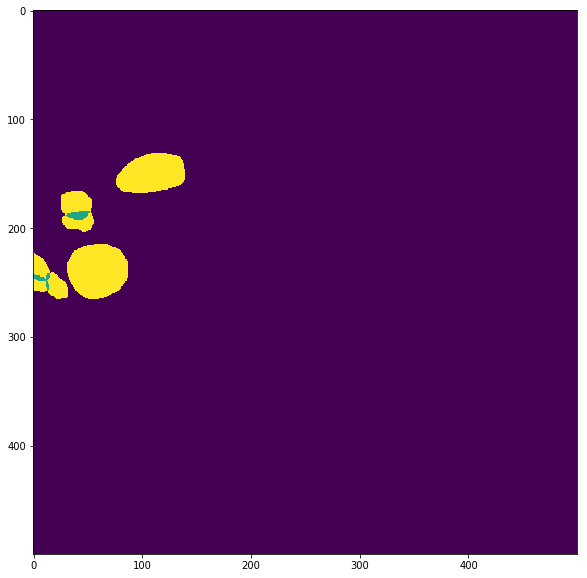

In [74]:
from skimage.io import imread, imshow
%matplotlib inline
plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
disp_width = 500
mask_show = np.array(Image.open(region_info[i]['file_name']))[0:disp_width,0:disp_width]
for j in range(len(list_candidate)):
    mask_sel = np.array(Image.open(list_candidate[j]['file_name']))[0:disp_width,0:disp_width]
    overlap = mask_sel & mask_show
    mask_show[overlap.nonzero()] = 150
    mask_sel[overlap.nonzero()] = 0
    mask_show = mask_show | mask_sel
ax.imshow(mask_show)
plt.show

<function matplotlib.pyplot.show>

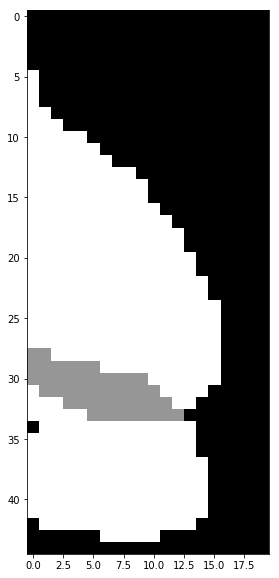

In [73]:
from skimage.io import imread, imshow
%matplotlib inline
plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)

mask_sel1 = np.array(Image.open(list_candidate[1]['file_name']))[215:260,0:20]
mask_sel2 = np.array(Image.open(list_candidate[2]['file_name']))[215:260,0:20]
overlap = mask_sel1 & mask_sel2
mask_show = mask_sel1 | mask_sel2
mask_show[overlap.nonzero()] = 150
ax.imshow(mask_show,cmap='gray')
plt.show


In [71]:
import pandas as pd
g1 = pd.DataFrame(overlap)
g1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
